<a href="https://colab.research.google.com/github/chuanluchen/NLP/blob/master/TextCNN%E4%B8%AD%E6%96%87%E6%96%B0%E9%97%BB%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ！！！！连接google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# ！！！！导入utils
import importlib.util
import sys

# 找到导入包所在文件夹
sys.path.append('drive/My Drive/Colab Notebooks') 
from utils import *

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,class_num=5,last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [ ]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# ！！！！路径配置
data_dir =  "/content/drive/My Drive/Colab Notebooks/processed_data" 
vocab_file = "/content/drive/My Drive/Colab Notebooks/vocab/vocab.txt"
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 64
embedding_dims = 50
epochs = 8

print('数据预处理与加载数据...')

# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_file)

# 全部数据
x, y = read_files(data_dir)
data = list(zip(x,y))
del x,y
# 乱序
random.shuffle(data)
# 切分训练集和测试集
train_data, test_data = train_test_split(data)
# 对文本的词id和类别id进行编码
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



数据预处理与加载数据...
对序列做padding，保证是 samples*timestep 的维度
x_train shape: (65810, 100)
x_test shape: (21937, 100)


In [ ]:
print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

#print('对测试集预测...')
#result = model.predict(x_test)

构建模型...
训练...
Epoch 1/8
1028/1029 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.8347
Epoch 00001: saving model to ./cnn_model.h5
1029/1029 [==============================] - 99s 96ms/step - loss: 0.4739 - accuracy: 0.8347 - val_loss: 0.2875 - val_accuracy: 0.8999
Epoch 2/8
1028/1029 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9472
Epoch 00002: saving model to ./cnn_model.h5
1029/1029 [==============================] - 98s 95ms/step - loss: 0.1556 - accuracy: 0.9472 - val_loss: 0.2916 - val_accuracy: 0.9046
Epoch 3/8
1028/1029 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9731
Epoch 00003: saving model to ./cnn_model.h5
1029/1029 [==============================] - 98s 95ms/step - loss: 0.0771 - accuracy: 0.9731 - val_loss: 0.3492 - val_accuracy: 0.9019
Epoch 4/8
1028/1029 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9813
Epoch 00004: saving model to ./cnn_model.h5
1029/1029 [======

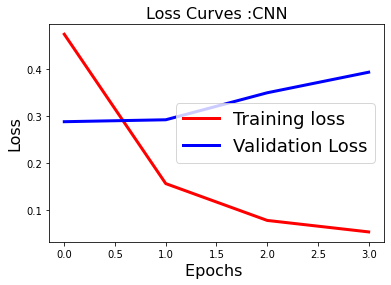

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

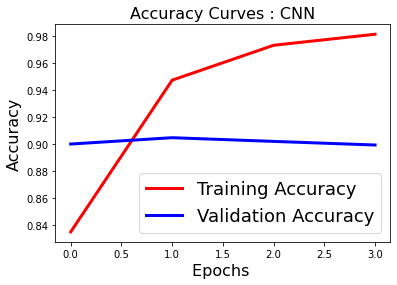

In [ ]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

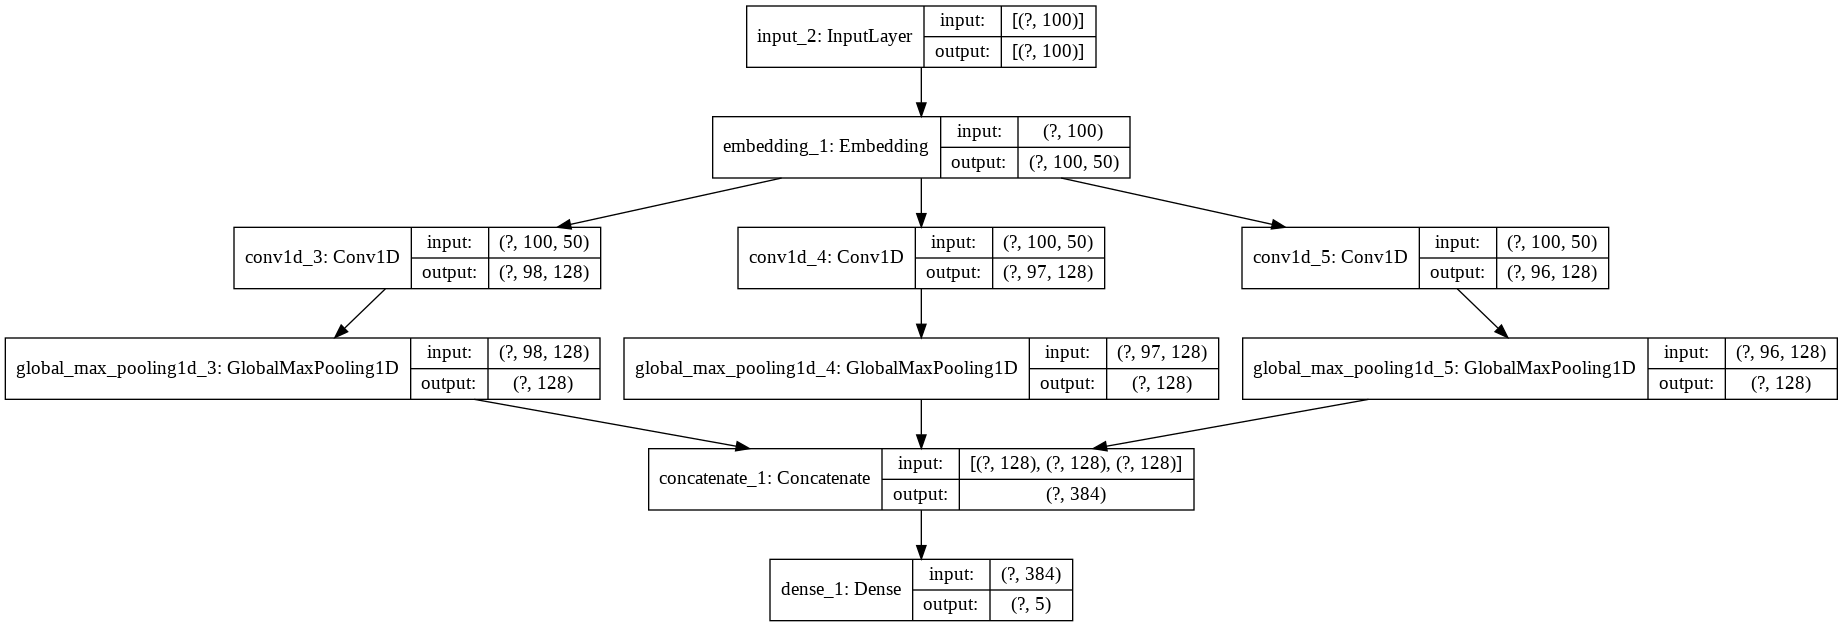

In [ ]:
from tensorflow.keras.utils import plot_model
# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)